In [34]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n' + '========'*8 + '%s'%nowtime)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' # 避免Jupter Notebook老是服务会挂掉
printbar()


================================================================2020-10-21 21:02:49


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

dftrain_raw = pd.read_csv('../eat_pytorch_in_20_days-master/eat_pytorch_in_20_days-master/data/titanic/train.csv')
dftest_raw = pd.read_csv('../eat_pytorch_in_20_days-master/eat_pytorch_in_20_days-master/data/titanic/test.csv')
dftrain_raw.head(10) # pd.head 代表的是行数

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


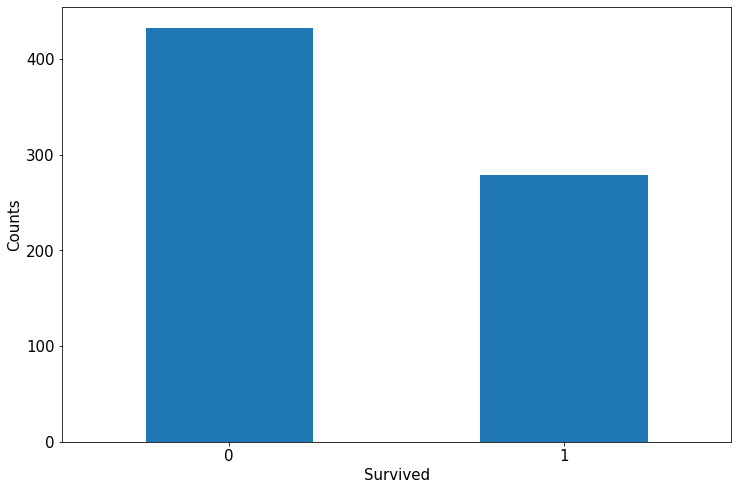

In [36]:
# 在jupyter中打印图片
%matplotlib inline
%config InlineBackend.figure_format = 'png' # 在默认设置的matplotlib中图片分辨率不是很高，可以通过设置矢量图的方式来提高图片显示质量
# ax = dftrain_raw['Survived'].value_counts() # 查看有多少个不同的值，并判断每个值的个数
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar',
                                                 figsize=(12,8),fontsize=15,rot=0) # plot是series的属性,可以在pandas的官方文档查看相关绘图参数
# rot是旋转刻度
ax.set_ylabel('Counts', fontsize = 15)
ax.set_xlabel('Survived', fontsize =15)
plt.show()


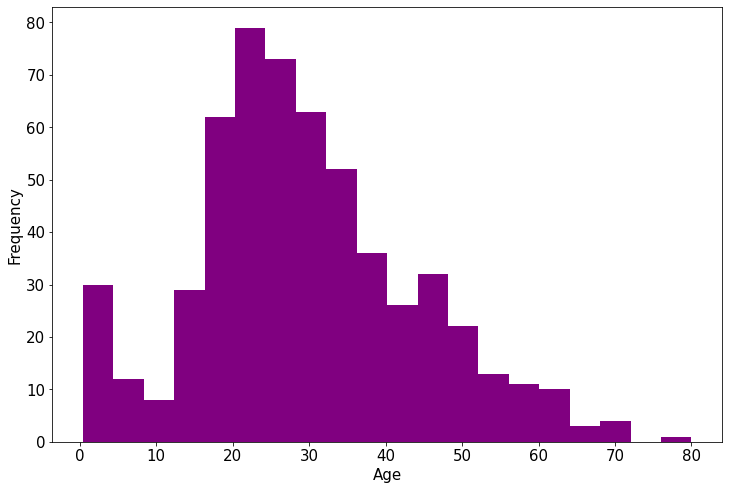

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)
# hist是直方图，bins控制直方图的间隔
ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

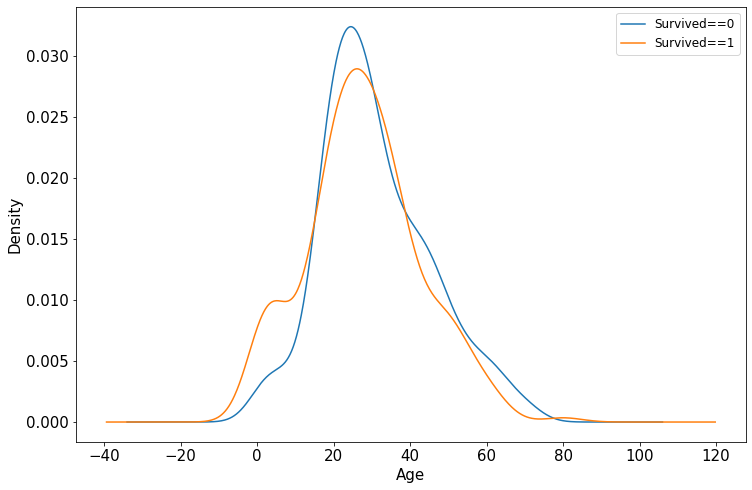

In [38]:
# 年龄和label的相关性
%matplotlib inline
%config InlineBackend.figure_format = 'png'
dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density', figsize = (12, 8), fontsize=15) # 密度图
dftrain_raw.query('Survived == 1')['Age'].plot(kind='density', figsize=(12, 8), fontsize=15)
plt.legend(['Survived==0', 'Survived==1'], fontsize=12)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()
# 这里的坐标轴绘制方法与原方法有差异，属于绘图的两种方法

In [39]:
# 数据预处理
def preprocessing(dfdata):
    dfresult = pd.DataFrame()
    # Pclass 乘客所持票类
    dfPclass = pd.get_dummies(dfdata['Pclass'])     # get_dummies生成哑变量
    dfPclass.columns = ['Pclass_' + str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult, dfPclass], axis=1) # 合并两个df数据 axis=1横向合并


    # Sex 性别
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    # Age
    dfresult['Age'] = dfdata['Age'].fillna(0) # 年龄缺失值用0填充
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32') # 添加年龄是否缺失作为辅助特征

    # SibSp,Parch,Fare 乘客兄弟姐妹/配偶的个数,乘客父母/孩子的个数,乘客所持票的价格
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    # Cabin 乘客所在的船舱
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32')

    # Embarked 乘客登船港口
    dfEmbarked = pd.get_dummies(dfdata['Embarked'], dummy_na=True) # dummy_na=True不忽略缺失值
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)

    return dfresult

x_train = preprocessing(dftrain_raw).values # 去除标题栏和index栏
y_train = dftrain_raw[['Survived']].values # 带两个[[]]可以带标题栏

x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[['Survived']].values

print('x_train.shape = ', x_train.shape)
print('x_test.shape = ', x_test.shape)

print('y_train.shape = ', y_train.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (712, 15)
x_test.shape =  (179, 15)
y_train.shape =  (712, 1)
y_test.shape =  (179, 1)


In [40]:
# 进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道
d1_train = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()),
                      shuffle = True, batch_size=8)
d1_valid = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float()),
                      shuffle=False, batch_size=8)
# shuffle是对数据进行排序 batch_size是每一批加载的数据个数
# TensorDataset前面是数据，后面是标签
print(d1_train)

In [41]:
for features, labels in d1_valid:
    print(features, labels)
    break

tensor([[  0.0000,   0.0000,   1.0000,   1.0000,   0.0000,   0.0000,   1.0000,
           8.0000,   2.0000,  69.5500,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   1.0000,   0.0000,  20.0000,   0.0000,
           0.0000,   0.0000,   8.6625,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   1.0000,   0.0000,   9.0000,   0.0000,
           3.0000,   2.0000,  27.9000,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   1.0000,   0.0000,  18.0000,   0.0000,
           1.0000,   0.0000, 227.5250,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   1.0000,   0.0000,   0.7500,   0.0000,
           2.0000,   1.0000,  19.2583,   1.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  0.0000,   1.0000,   0.0000,   1.0000,   0.0000,  28.0000,   0.0000,
           0.0000,   0.0000,  1

In [42]:
def creat_net():
    net = nn.Sequential() # 放置神经网络的有序容器
    # Adds a child module to the current module. The module can be accessed as an attribute using the given name.
    net.add_module('linear1', nn.Linear(15,20)) # 线性变换，即y=xA'+b 输入n*15，输出n*20
    net.add_module('relu1', nn.ReLU()) # 激活函数 max(0,x)
    net.add_module('linear2', nn.Linear(20,15))
    net.add_module('relu2', nn.ReLU())
    net.add_module("linear3",nn.Linear(15,1))
    net.add_module('sigmoid', nn.Sigmoid()) # 激活函数 sigmoid
    return net

net = creat_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [43]:
# 可视化模型的层次结构和参数
from torchkeras import summary
summary(net, input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


In [61]:
# 脚本形式训练循环
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss() # 损失函数 计算目标值与预测值之间的二进制交叉熵损失函数
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01) # torch.optim 构造优化器对象，包含了多种优化算法 Adam表示Adam优化算法
metric_func = lambda y_pred, y_true: accuracy_score(y_true.data.numpy(), y_pred.data.numpy() > 0.5)
metric_name = 'accuracy'



Epoch(时期):当一个完整的数据集通过了神经网络一次并且返回了一次，这个过程称为一次>epoch。（也就是说，所有训练样本在神经网络中都 进行了一次正向传播 和一次反向传播 ）
再通俗一点，一个Epoch就是将所有训练样本训练一次的过程。

Batch（批 / 一批样本）：
将整个训练样本分成若干个Batch。

Batch_Size（批大小）：
每批样本的大小。

Iteration（一次迭代）：
训练一个Batch就是一次Iteration（这个概念跟程序语言中的迭代器相似）。

In [62]:
epochs = 10
log_step_freq = 30
dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('Start Training...')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s'%nowtime)


for epoch in range(1, epochs+1):

    # 1, 训练循环-----------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    # enumerate(X， [start=0]) 枚举 start是起始计数值，默认从0开始
    for step, (features, labels) in enumerate(d1_train, 1):
        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)

        loss = loss_func(predictions, labels)
        metric = metric_func(predictions, labels)

        # 反向传播求梯度
        loss.backward()
        optimizer.step() # 这个方法可以更新所有的参数

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(('[step = %d] loss: %.3f, ' + metric_name + ': %.3f') %
                  (step, loss_sum / step, metric_sum/step))
    # 2, 验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features, labels) in enumerate(d1_valid, 1):
        # 关闭梯度计算
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            val_metric = metric_func(predictions, labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3, 记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info # 往dfhistory中存储数据

    # 打印epoch级别日志
    print(('\nEPOCH = %d, loss = % .3f,'+metric_name + ' = %.3f, val_loss = %.3f,' + 'val_' + metric_name+ ' = %.3f')%info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n' + '============'*8 + '%s'%nowtime)

print('Finished Training...')

Start Training...
================================================================2020-10-21 21:30:43
[step = 30] loss: 0.415, accuracy: 0.817
[step = 60] loss: 0.396, accuracy: 0.827

EPOCH = 1, loss =  0.377,accuracy = 0.846, val_loss = 0.409,val_accuracy = 0.821

================================================================================================2020-10-21 21:30:43
[step = 30] loss: 0.427, accuracy: 0.817
[step = 60] loss: 0.389, accuracy: 0.844

EPOCH = 2, loss =  0.392,accuracy = 0.840, val_loss = 0.402,val_accuracy = 0.826

================================================================================================2020-10-21 21:30:43
[step = 30] loss: 0.378, accuracy: 0.821
[step = 60] loss: 0.376, accuracy: 0.831

EPOCH = 3, loss =  0.384,accuracy = 0.837, val_loss = 0.407,val_accuracy = 0.810

================================================================================================2020-10-21 21:30:43
[step = 30] loss: 0.372, accuracy: 0.846
[step = 60] lo

In [58]:
dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.387287,0.834270,0.388540,0.804348
1,2.0,0.370018,0.834270,0.385080,0.826087
2,3.0,0.382142,0.839888,0.396556,0.804348
3,4.0,0.394373,0.831461,0.413050,0.804348
4,5.0,0.386850,0.839888,0.409785,0.815217
5,6.0,0.382413,0.844101,0.380841,0.815217
6,7.0,0.372250,0.831461,0.404118,0.809783
7,8.0,0.381755,0.841292,0.403707,0.815217
8,9.0,0.379713,0.842697,0.381176,0.826087
9,10.0,0.369489,0.845506,0.414150,0.820652


In [63]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--') # bo-- 是控制绘图线条参数
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    plt.show()

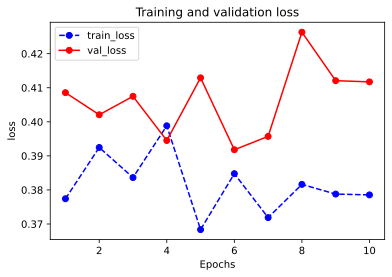

In [64]:
plot_metric(dfhistory, 'loss')